<a href="https://colab.research.google.com/github/mervegb/collaborative-filtering/blob/main/collaborative_filtering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ratings = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/ratings.csv')

In [3]:
movies = pd.read_csv('https://s3-us-west-2.amazonaws.com/recommender-tutorial/movies.csv')

In [4]:
n_ratings = len(ratings)
n_movies = ratings['movieId'].nunique()
n_users = ratings['userId'].nunique()

print(f"Number of ratings: {n_ratings}")
print(f"Number of unique movieIds: {n_movies}")
print(f"Number of unique users: {n_users}")
print(f"Average number of ratings per user: {round(n_ratings/n_users,2)}")
print(f"Average number of ratings per movie: {round(n_ratings/n_movies, 2)}")

Number of ratings: 100836
Number of unique movieIds: 9724
Number of unique users: 610
Average number of ratings per user: 165.3
Average number of ratings per movie: 10.37


<ipython-input-5-1574b7711e73>:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="rating", data=ratings, palette="viridis")


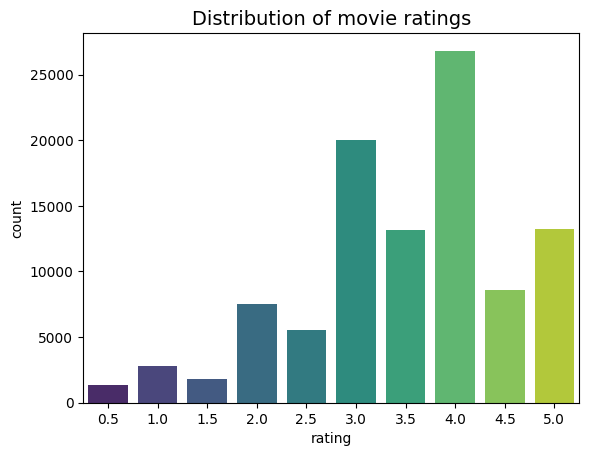

In [5]:
sns.countplot(x="rating", data=ratings, palette="viridis")
plt.title("Distribution of movie ratings", fontsize=14)
plt.show()

In [6]:
print(f"Mean global rating: {round(ratings['rating'].mean(),2)}.")

mean_ratings = ratings.groupby('userId')['rating'].mean()
print(f"Mean rating per user: {round(mean_ratings.mean(),2)}.")

Mean global rating: 3.5.
Mean rating per user: 3.66.


In [7]:
#movies most frequently rated
movie_ratings = ratings.merge(movies,on="movieId") #merges ratings & movies based on movieId column
movie_ratings["title"].value_counts()[0:10] #value_counts() method counts the occurences of each unique value in the title column

,count
title,
Forrest Gump (1994),329
"Shawshank Redemption, The (1994)",317
Pulp Fiction (1994),307
"Silence of the Lambs, The (1991)",279
"Matrix, The (1999)",278
Star Wars: Episode IV - A New Hope (1977),251
Jurassic Park (1993),238
Braveheart (1995),237
Terminator 2: Judgment Day (1991),224


In [8]:
#which movie has the lowest and highest average rating
mean_ratings = ratings.groupby("movieId")[["rating"]].mean()

lowest_rated = mean_ratings["rating"].idxmin()
movies[movies['movieId']==lowest_rated] #return the movie with the lowest average rating

,movieId,title,genres
2689,3604,Gypsy (1962),Musical


In [9]:
highest_rated = mean_ratings["rating"].idxmax()
movies[movies["movieId"] == highest_rated] #return the movie with the highest average rating

,movieId,title,genres
48,53,Lamerica (1994),Adventure|Drama


Lamarica may be the highest rated movie but it only has 2 ratings. Better approach for evaluating movie popularity is to look at Bayesian average.

#Bayesian Average
Provide more reliable rakings by adressing potential biases in the raw average.

For example, a movie with only few ratings might have a high raw average but using Bayesian average gives more weight to prior knowledge.

In [10]:
#for each movie, calculate how many times that movie has been rated & average rating each movie has received
movie_stats = ratings.groupby("movieId")["rating"].agg(["count", "mean"])
movie_stats.head()

,count,mean
movieId,,
1,215,3.920930
2,110,3.431818
3,52,3.259615
4,7,2.357143
5,49,3.071429


In [11]:
C = movie_stats["count"].mean()
m = movie_stats["mean"].mean()

print(f"Average number of ratings for a given movie: {C:.2f}")
print(f"Average rating for a given movie: {m:.2f}")

def bayesian_avg(ratings):
  bayesian_avg = (C*m+ratings.sum())/(C+ratings.count())
  return round(bayesian_avg, 3)

Average number of ratings for a given movie: 10.37
Average rating for a given movie: 3.26


In [12]:
lamerica = pd.Series([5,5])
bayesian_avg(lamerica)

3.543

In [13]:
#apply bayesian avg to all movies in our dataset
bayesian_avg_ratings = ratings.groupby("movieId")["rating"].agg(bayesian_avg).reset_index()
bayesian_avg_ratings.columns = ["movieId", "bayesian_avg"]
movie_stats = movie_stats.merge(bayesian_avg_ratings, on="movieId")

In [14]:
movie_stats = movie_stats.merge(movies[["movieId", "title"]])
movie_stats.sort_values("bayesian_avg", ascending=False).head()

#Using the bayesian avg, these are the most highly rated movies

,movieId,count,mean,bayesian_avg,title
277,318,317,4.429022,4.392,"Shawshank Redemption, The (1994)"
659,858,192,4.289062,4.236,"Godfather, The (1972)"
2224,2959,218,4.272936,4.227,Fight Club (1999)
224,260,251,4.231076,4.193,Star Wars: Episode IV - A New Hope (1977)
46,50,204,4.237745,4.191,"Usual Suspects, The (1995)"


In [15]:
#movie datasets needs to be cleaned in 2 ways: genres & title

movies['genres'] = movies['genres'].apply(lambda x: x.split("|") if isinstance(x, str) else x)
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),"[Adventure, Animation, Children, Comedy, Fantasy]"
1,2,Jumanji (1995),"[Adventure, Children, Fantasy]"
2,3,Grumpier Old Men (1995),"[Comedy, Romance]"
3,4,Waiting to Exhale (1995),"[Comedy, Drama, Romance]"
4,5,Father of the Bride Part II (1995),[Comedy]


In [16]:
#how many movie genres are there
from collections import Counter #to count the occurences of objects


#iterate over each list of genres in the movies["genres"] column, flatten those lists into individual genres, count how many times each genre appears using Counter
genre_frequency = Counter(g for genres in movies['genres'] for g in genres)
genre_frequency

Counter({'Adventure': 1263,
         'Animation': 611,
         'Children': 664,
         'Comedy': 3756,
         'Fantasy': 779,
         'Romance': 1596,
         'Drama': 4361,
         'Action': 1828,
         'Crime': 1199,
         'Thriller': 1894,
         'Horror': 978,
         'Mystery': 573,
         'Sci-Fi': 980,
         'War': 382,
         'Musical': 334,
         'Documentary': 440,
         'IMAX': 158,
         'Western': 167,
         'Film-Noir': 87,
         '(no genres listed)': 34})

In [17]:
print("The most common movie genres are:\n", genre_frequency.most_common(5))

The most common movie genres are:
 [('Drama', 4361), ('Comedy', 3756), ('Thriller', 1894), ('Action', 1828), ('Romance', 1596)]


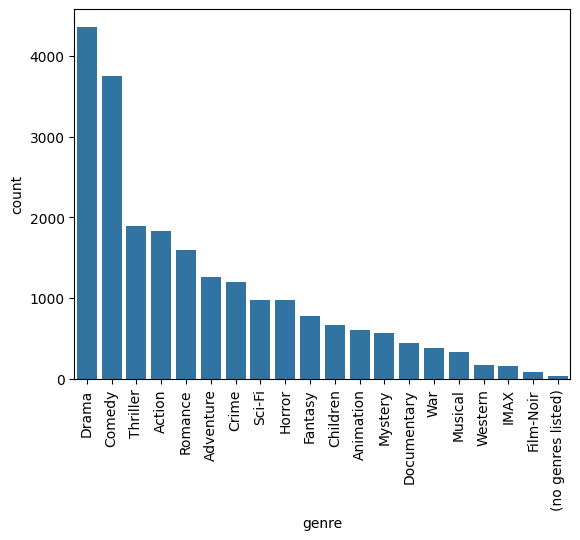

In [18]:
#visualize genres popularity with a bar plot
genre_frequency_df = pd.DataFrame([genre_frequency]).T.reset_index()
genre_frequency_df.columns = ["genre", "count"]

sns.barplot(x="genre", y="count", data=genre_frequency_df.sort_values(by="count", ascending=False))
plt.xticks(rotation=90)
plt.show()

In [19]:
#First step is to transform our data into a user-item matrix
#In this matrix, rows represents users and columns represent movies
#user_mapper => maps user id to user index
#movie_mapper => maps movie id to movie index
#user_inv_mapper => maps user index to user id
#movie_inv_mapper => maps movie index to movie id

# Inverse mappings are useful if you want to look up to the original user or movie id from a matrix index

from scipy.sparse import csr_matrix


def create_X(df):
  """
    Generates a sparse matrix from ratings dataframe.

    Args:
        df: pandas dataframe containing 3 columns (userId, movieId, rating)

    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        movie_mapper: dict that maps movie id's to movie indices
        movie_inv_mapper: dict that maps movie indices to movie id's
    """

  M = df['userId'].nunique() #number of unique users
  N = df['movieId'].nunique() #number of unique movies

  #mapper is a dictionary that helps us translate real-world IDs into continuous row and column indices
  #user_mapper maps user IDs to row numbers in the matrix
  user_mapper = dict(zip(np.unique(df["userId"]), list(range(M))))

  #movie_mapper maps movie IDs to column numbers in the matrix
  movie_mapper = dict(zip(np.unique(df["movieId"]), list(range(N)))) #movie_mapper = {10: 0, 20: 1, 30: 2}

  #inverse of user_mapper, maps row index back to the original userId
  user_inv_mapper = dict(zip(list(range(M)), np.unique(df["userId"])))

  #inverse of movie_mapper, maps column index back to the original movieId
  movie_inv_mapper = dict(zip(list(range(N)), np.unique(df["movieId"]))) #movie_inv_mapper = {0: 10, 1: 20, 2: 30}


  user_index = [user_mapper[i] for i in df['userId']]
  item_index = [movie_mapper[i] for i in df['movieId']]

  X = csr_matrix((df["rating"], (user_index, item_index)), shape=(M, N))

  return X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper

X, user_mapper, movie_mapper, user_inv_mapper, movie_inv_mapper = create_X(ratings)

In [20]:
X.shape #our X matrix contains 610 users and 9724 movies

(610, 9724)

In [21]:
#Evaluating sparsity
#We calculate sparsity by dividing the number of stored elements by total number of elements
n_total = X.shape[0]*X.shape[1]
n_ratings = X.nnz
sparsity = n_ratings/n_total
print(f"Matrix sparsity: {round(sparsity*100,2)}%")


#Cold Start problem is when there are new users and movies in our matrix that don't have any ratings

Matrix sparsity: 1.7%


In [22]:
n_ratings_per_user = X.getnnz(axis=1)
len(n_ratings_per_user)

610

In [23]:
print(f"Most active user rated {n_ratings_per_user.max()} movies.")
print(f"Least active user rated {n_ratings_per_user.min()} movies.")

Most active user rated 2698 movies.
Least active user rated 20 movies.


In [24]:
n_ratings_per_movie = X.getnnz(axis=0)
len(n_ratings_per_movie)

9724

In [25]:
print(f"Most rated movie has {n_ratings_per_movie.max()} ratings.")
print(f"Least rated movie has {n_ratings_per_movie.min()} ratings.")

Most rated movie has 329 ratings.
Least rated movie has 1 ratings.


<ipython-input-26-81aabc7d014b>:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_user,shade=True)
<ipython-input-26-81aabc7d014b>:9: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(n_ratings_per_movie,shade=True)


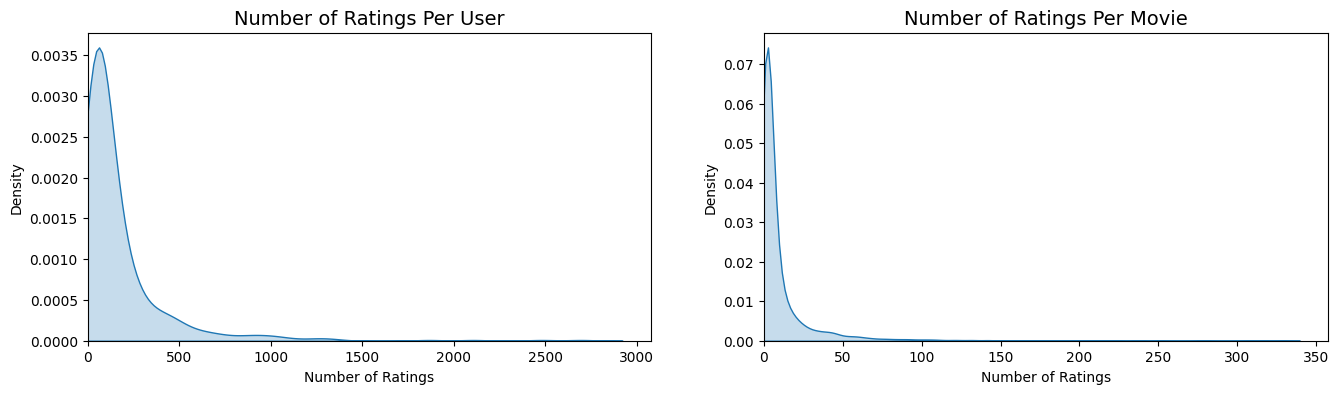

In [26]:
plt.figure(figsize=(16,4))
plt.subplot(1,2,1)
sns.kdeplot(n_ratings_per_user,shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per User", fontsize=14)
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.subplot(1,2,2)
sns.kdeplot(n_ratings_per_movie,shade=True)
plt.xlim(0)
plt.title("Number of Ratings Per Movie", fontsize=14)
plt.xlabel("Number of Ratings")
plt.ylabel("Density")
plt.show()

# How KNN compares movies based on user ratings?

When KNN compares two movies, it looks at how similar their rating vectors are across all users.

Example:
Movie A: Rated by 3 users as [5, 3, 4].
Movie B: Rated by the same 3 users as [5, 3, 4].

KNN will measure the distance (or similarity) between these two vectors. In this case, the vectors are identical, so the distance between them is zero. Therefore, KNN will determine that Movie A and Movie B are very similar (in fact, identical based on the ratings).

This approach allows KNN to recommend movies that have been rated similarly by users.



In [27]:
#Item-Item Recommendations with K-Nearest Neighbors
#We need to find the k movies that have most similar user engagement vectors for movie i
from sklearn.neighbors import NearestNeighbors

def find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, k, metric='cosine'):
    """
    Finds k-nearest neighbours for a given movie id.

    Args:
        movie_id: id of the movie of interest
        X: user-item utility matrix
        k: number of similar movies to retrieve
        metric: distance metric for kNN calculations

    Output: returns list of k similar movie ID's
    """

    #To compute similarity, KNN expects each to represent a data point,

    X = X.T #Transpose matrix to switch between users and movies
    neighbour_ids = []

    movie_ind = movie_mapper[movie_id]
    movie_vec = X[movie_ind]

    if isinstance(movie_vec,(np.ndarray)): #reshape if necessary
      movie_vec = movie_vec.reshape(1,-1)

    #k+1 => discard the movie itself and still have k actual neighbors
    kNN = NearestNeighbors(n_neighbors=k+1, algorithm="brute", metric=metric)
    kNN.fit(X)
    neighbour = kNN.kneighbors(movie_vec, return_distance=False)

    for i in range(0,k):
        n = neighbour.item(i)
        neighbour_ids.append(movie_inv_mapper[n])
    neighbour_ids.pop(0)
    return neighbour_ids

In [28]:
similar_movies = find_similar_movies(1, X, movie_mapper, movie_inv_mapper, k=10)
similar_movies

#find_similar_movies() returns a list of movieId's that are most similar to your movie of interest

[3114, 480, 780, 260, 356, 364, 1210, 648, 1265]

In [29]:
movie_titles = dict(zip(movies["movieId"], movies["title"]))
movie_id = 1
similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='cosine', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])


#These recommendations are based solely on user-item ratings, movie features such as genres are not used in this approach

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Jurassic Park (1993)
Independence Day (a.k.a. ID4) (1996)
Star Wars: Episode IV - A New Hope (1977)
Forrest Gump (1994)
Lion King, The (1994)
Star Wars: Episode VI - Return of the Jedi (1983)
Mission: Impossible (1996)
Groundhog Day (1993)


In [30]:
#you can also use "euclidean" or "manhattan" distance instead of "cosine"
movie_id = 1

similar_movies = find_similar_movies(movie_id, X, movie_mapper, movie_inv_mapper, metric='euclidean', k=10)
movie_title = movie_titles[movie_id]

print(f"Because you watched {movie_title}:")
for i in similar_movies:
    print(movie_titles[i])

Because you watched Toy Story (1995):
Toy Story 2 (1999)
Mission: Impossible (1996)
Independence Day (a.k.a. ID4) (1996)
Bug's Life, A (1998)
Nutty Professor, The (1996)
Willy Wonka & the Chocolate Factory (1971)
Babe (1995)
Groundhog Day (1993)
Mask, The (1994)


In [31]:
#Handling Cold-Start problem
#Collaborative filtering relies solely on user-item interactions within the utility matrix
#Issue with this approach is that brand new users or items with no interactions get excluded from the recommendation systems
#Content based filtering is a way to handle cold-start proble by generating recommendations based on user and item features

n_movies = movies["movieId"].nunique()
print(f"There are {n_movies} unique movies in our movies dataset")

There are 9742 unique movies in our movies dataset


In [35]:
#This transformation is common preprocessing in ml, where categorical features like genres are transformed
#into binary features (one-hot encoding) for use in algorithms that require numerical inputs

#set comprehension to get unique genres
genres = set(genre for genre_list in movies["genres"] for genre in genre_list)

#This loop will create a column for every genre in genres, resulting in binary encoding for each genre
for genre in genres:
  movies[genre] = movies.genres.transform(lambda x: int(genre in x))

movie_genres = movies.drop(columns=["movieId", "title", "genres"])

In [36]:
movie_genres.head()

,Horror,War,Adventure,Film-Noir,Sci-Fi,Romance,Children,Drama,Musical,Western,Fantasy,IMAX,(no genres listed),Action,Mystery,Comedy,Crime,Animation,Thriller,Documentary
0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0
1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0


In [37]:
from sklearn.metrics.pairwise import cosine_similarity

cosine_sim = cosine_similarity(movie_genres, movie_genres)
print(f"Dimensions of our genres cosine similarity matrix: {cosine_sim.shape}")

Dimensions of our genres cosine similarity matrix: (9742, 9742)


In [39]:
pip install fuzzywuzzy

In [40]:
#fuzzywuzzy library will find the most similar title to a string that you pass in

from fuzzywuzzy import process

def movie_finder(title):
  all_titles = movies["title"].tolist()
  closest_match = process.extractOne(title, all_titles)[0]
  return closest_match

/usr/local/lib/python3.10/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [42]:
title = movie_finder('to story')
title

'Toy Story (1995)'

In [43]:
#To get relevant recommendations, we need to find its index in cosine similarity matrix
# We can create a movie index mapper => maps a movie title to the index that it represents in our matrix

movie_idx = dict(zip(movies["title"], list(movies.index)))
idx = movie_idx[title]
print(f"Movie index for Toy Story: {idx}")

Movie index for Toy Story: 0


In [44]:
n_recommendations = 10
sim_scores = list(enumerate(cosine_sim[idx])) #generates a list of similarit scores for movie you're interested in based on cosine similarity
sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True) #sorts movies by their cosine similarity in desc
sim_scores = sim_scores[1:(n_recommendations+1)] #remove the first element from the list because it's the movie itself
movie_indices = [i[0] for i in sim_scores]


In [45]:
print(f"Because you watched {title}:")
movies['title'].iloc[similar_movies]

Because you watched Toy Story (1995):


,title
3114,"Greatest Story Ever Told, The (1965)"
648,Chain Reaction (1996)
780,Cinderella (1950)
2355,Toy Story 2 (1999)
788,Bedknobs and Broomsticks (1971)
1073,Jerry Maguire (1996)
34,It Takes Two (1995)
1265,Sliding Doors (1998)
367,Blown Away (1994)


In [46]:
def get_content_based_recommendations(title_string, n_recommendations=10):
    title = movie_finder(title_string)
    idx = movie_idx[title]
    sim_scores = list(enumerate(cosine_sim[idx]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    sim_scores = sim_scores[1:(n_recommendations+1)]
    similar_movies = [i[0] for i in sim_scores]
    print(f"Because you watched {title}:")
    print(movies['title'].iloc[similar_movies])

In [47]:
get_content_based_recommendations('toy story', 5)

Because you watched Toy Story (1995):
1706                                       Antz (1998)
2355                                Toy Story 2 (1999)
2809    Adventures of Rocky and Bullwinkle, The (2000)
3000                  Emperor's New Groove, The (2000)
3568                             Monsters, Inc. (2001)
Name: title, dtype: object
